# EDA

In [1]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [2]:
import sys
sys.path.append('/home/work')

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import split, col, avg, count, desc, min, max
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data.utils.data_loader import load_file_from_hdfs

In [4]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[*]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.app.submitTime', '1717050978805')
('spark.driver.host', 'dac583b3c46a')
('spark.app.id', 'local-1717050979580')
('spark.executor.id', 'driver')
('spark.driver.port', '33367')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDi

In [5]:
# Load the dataset
song_ratings_file_path = "raw/train/train_2.txt"
song_ratings = load_file_from_hdfs(song_ratings_file_path).cache()

song_attributes_file_path = "song-attributes.txt"
song_attributes = load_file_from_hdfs(song_attributes_file_path).cache()

genre_hierarchy_file_path = "genre-hierarchy.txt"
genre_hierarchy = load_file_from_hdfs(genre_hierarchy_file_path).cache()

In [ ]:
def check_missing_values(df):
    null_columns = {column: df.filter(col(column).isNull()).count() for column in df.columns}
    print(null_columns)
    return None

In [ ]:
def song_ratings_eda(df):
    df.show(5)
    
    print("The schema of the song ratings dataframe:")
    df.printSchema()

    print("Summary Statistics:")
    df.summary().show()
    
    ratings = df.count()
    print("Number of ratings: ", ratings)
    
    rating_range = df.agg(min("rating").alias("min_rating"), max("rating").alias("max_rating")).collect()[0]
    print("Range of ratings:", rating_range)
    
    avg_rating = df.agg({"rating": "avg"}).collect()[0][0]
    print("Average rating:", avg_rating)
    
    users = df.groupBy("user_id").count()
    print("Number of unique users: ", users.count())

    songs = df.groupBy("song_id").count()
    print("Number of unique songs: ", songs.count())

    return None

In [ ]:
def song_attributes_eda(df):
    df.show(5)
    
    print("The schema of the song attributes dataframe:")
    df.printSchema()

    artists = df.groupBy("artist_id").count()
    print("Number of unique artist: ", artists.count())
    
    albums = df.groupBy("album_id").count()
    print("Number of unique artist: ", albums.count())
    
    return None

In [ ]:
def genre_hierarchy_eda(df):
    df.show(5)
    
    print("The schema of the genre dataframe:")
    df.printSchema()

    genres = df.groupBy("genre_id").count()
    print("Number of unique genre: ", genres.count())
    
    return None

##### Display first 5 row of song ratings dataframe

In [ ]:
song_ratings.show(5)

In [ ]:
song_attributes.show(5)

In [ ]:
genre_hierarchy.show(5)

##### Update column names

In [6]:
song_ratings = song_ratings.withColumnRenamed("_c0", "user_id") \
    .withColumnRenamed("_c1", "song_id") \
    .withColumnRenamed("_c2", "rating") 

song_attributes = song_attributes.withColumnRenamed("_c0", "song_id") \
    .withColumnRenamed("_c1", "album_id") \
    .withColumnRenamed("_c2", "artist_id") \
    .withColumnRenamed("_c3", "genre_id")

genre_hierarchy = genre_hierarchy.withColumnRenamed("_c0", "genre_id") \
    .withColumnRenamed("_c1", "parent_genre_id") \
    .withColumnRenamed("_c2", "level") \
    .withColumnRenamed("_c3", "genre_name")

##### Check for missing values

In [ ]:
check_missing_values(song_ratings)
check_missing_values(song_attributes)
check_missing_values(genre_hierarchy)

##### Drop duplicates

In [ ]:
song_ratings = song_ratings.dropDuplicates()
song_attributes = song_attributes.dropDuplicates()
genre_hierarchy = genre_hierarchy.dropDuplicates()

##### EDA

In [19]:
spark.catalog.clearCache()

In [ ]:
song_ratings_eda(song_ratings)
song_attributes_eda(song_attributes)
genre_hierarchy_eda(genre_hierarchy)

##### Join song_ratings with song_attributes and genre_hierarchy

In [7]:
df = song_ratings.join(song_attributes, "song_id", how="inner")
df = df.join(genre_hierarchy,"genre_id", how="inner")

In [ ]:
df.printSchema()

In [ ]:
check_missing_values(df)

In [ ]:
df.show(5)

##### Visualizations

Genre Rating Distribution

In [8]:
df = df.sample(withReplacement=False, fraction=1.0, seed=42)

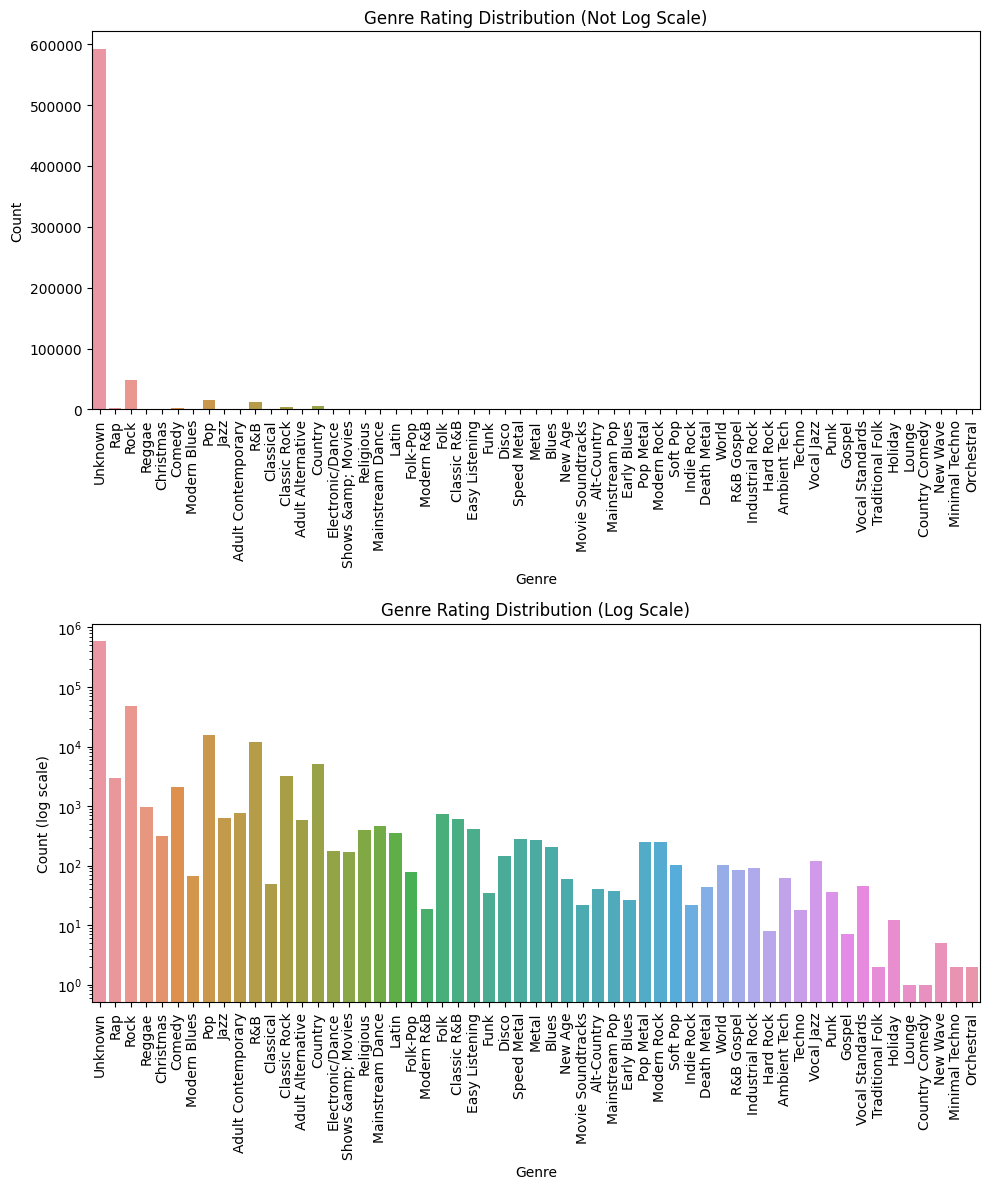

In [18]:
genre_pdf = df.select('genre_name').toPandas()
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# no log
sns.countplot(data=genre_pdf, x='genre_name', ax=axes[0])
axes[0].set_title('Genre Rating Distribution (Not Log Scale)')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# log
sns.countplot(data=genre_pdf, x='genre_name', ax=axes[1])
axes[1].set_title('Genre Rating Distribution (Log Scale)')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Count (log scale)')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Rating Spread by Genre

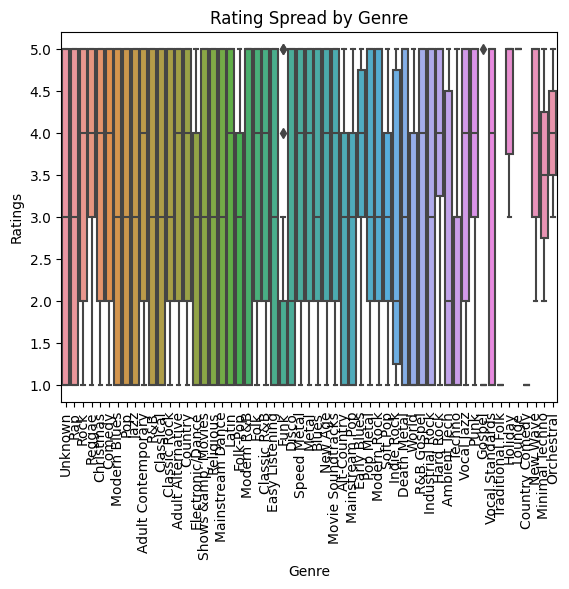

In [21]:
pdf = df.toPandas()
sns.boxplot(data=pdf, x='genre_name', y='rating')
plt.title('Rating Spread by Genre')
plt.xlabel('Genre')
plt.ylabel('Ratings')
plt.xticks(rotation=90)
plt.show()

Average Ratings by Genre

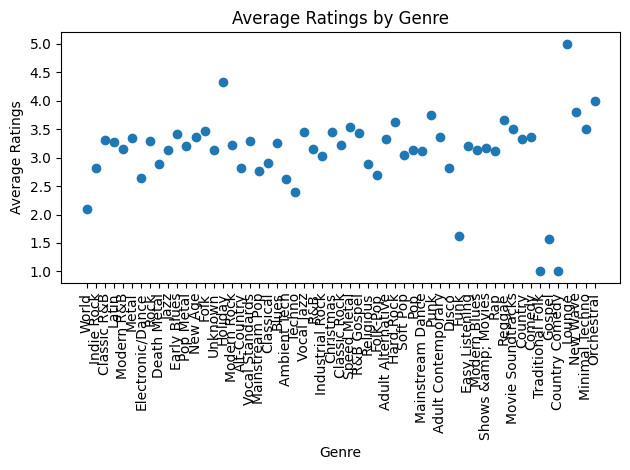

In [23]:
genre_rating_avg_pdf = df.groupBy('genre_name').avg('rating').toPandas()

plt.scatter(data=genre_rating_avg_pdf, x='genre_name', y='avg(rating)')
plt.title('Average Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Ratings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

top 10 artist

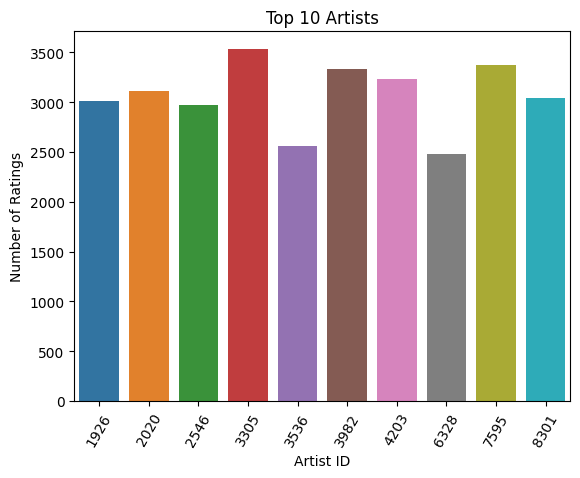

In [24]:
# top 10 artist (detemined by number of ratings)
artist_ratings_count = df.groupBy('artist_id').count()
top_10_artists = artist_ratings_count.orderBy('count', ascending=False).limit(10)
top_10_artists_pdf= top_10_artists.toPandas()

sns.barplot(data=top_10_artists_pdf, x='artist_id', y='count')
plt.title('Top 10 Artists')
plt.xlabel('Artist ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=60)
plt.show()


Average Ratings by Top Artists

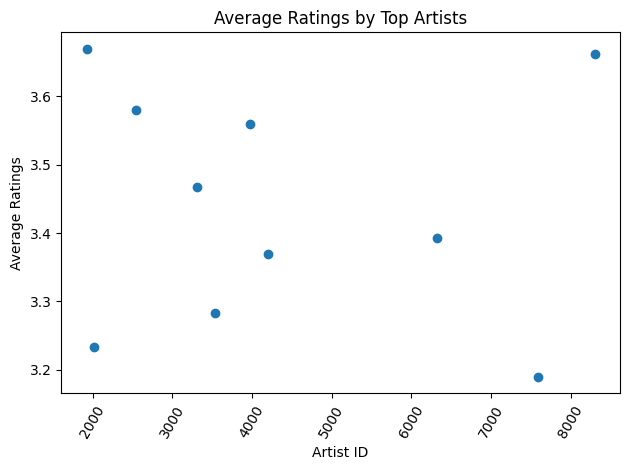

In [26]:
top_10_artists_df = top_10_artists.join(df, 'artist_id', 'inner')
top_artists_rating_avg_pdf= top_10_artists_df.groupBy('artist_id').avg('rating').toPandas()

plt.scatter(data=top_artists_rating_avg_pdf, x='artist_id', y='avg(rating)')
plt.title('Average Ratings by Top Artists')
plt.xlabel('Artist ID')
plt.ylabel('Average Ratings')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

Rating Spread by Top 10 Artists

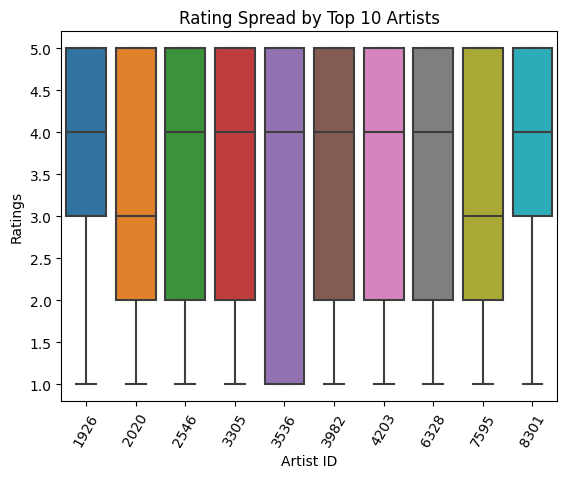

In [28]:
sns.boxplot(data=top_10_artists_df.toPandas(), x='artist_id', y='rating')
plt.title('Rating Spread by Top 10 Artists')
plt.xlabel('Artist ID')
plt.ylabel('Ratings')
plt.xticks(rotation=60)
plt.show()

Top 10 Songs

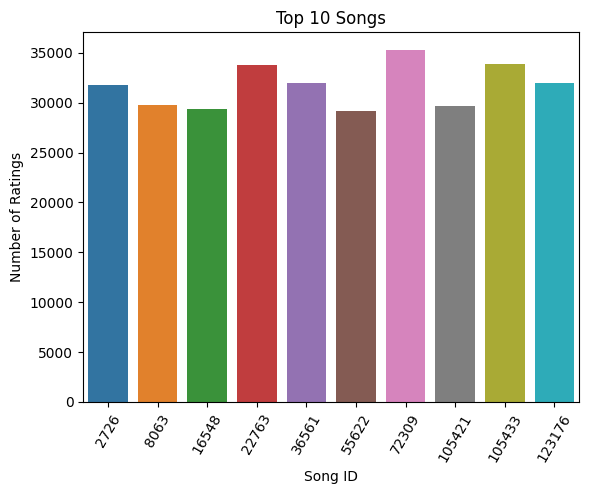

In [11]:
song_ratings_count = df.groupBy('song_id').count()
top_10_songs = song_ratings_count.orderBy('count', ascending=False).limit(10)
top_10_songs_pdf= top_10_songs.toPandas()

sns.barplot(data=top_10_songs_pdf, x='song_id', y='count')
plt.title('Top 10 Songs')
plt.xlabel('Song ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=60)
plt.show()

Average Ratings by Top Songs

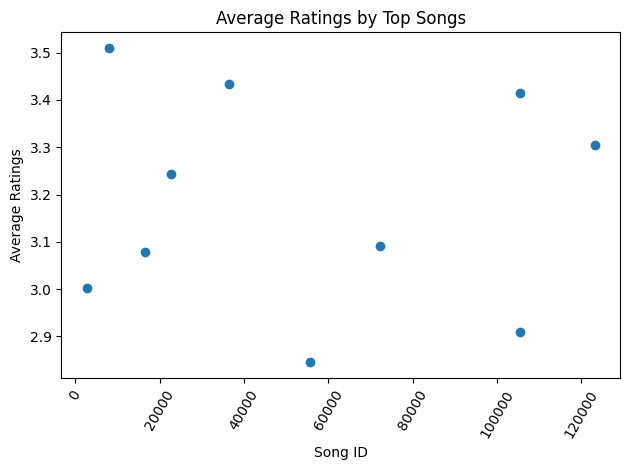

In [14]:
top_10_songs_df = top_10_songs.join(df, 'song_id', 'inner')
top_songs_rating_avg_pdf= top_10_songs_df.groupBy('song_id').avg('rating').toPandas()

plt.scatter(data=top_songs_rating_avg_pdf, x='song_id', y='avg(rating)')
plt.title('Average Ratings by Top Songs')
plt.xlabel('Song ID')
plt.ylabel('Average Ratings')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

Rating Spread by Top 10 Songs

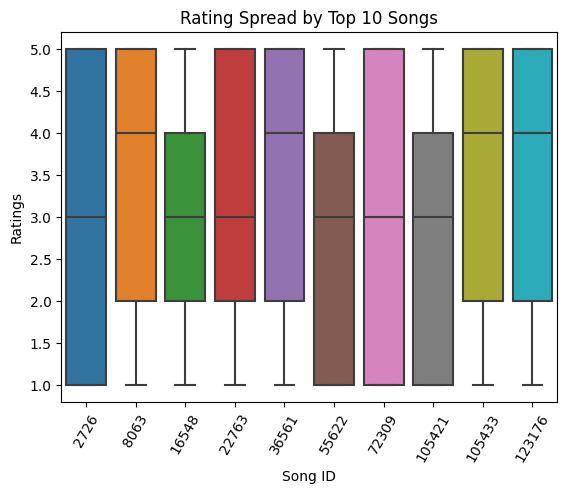

In [16]:
sns.boxplot(data=top_10_songs_df.toPandas(), x='song_id', y='rating')
plt.title('Rating Spread by Top 10 Songs')
plt.xlabel('Song ID')
plt.ylabel('Ratings')
plt.xticks(rotation=60)
plt.show()

Songs Breakdown by Genre

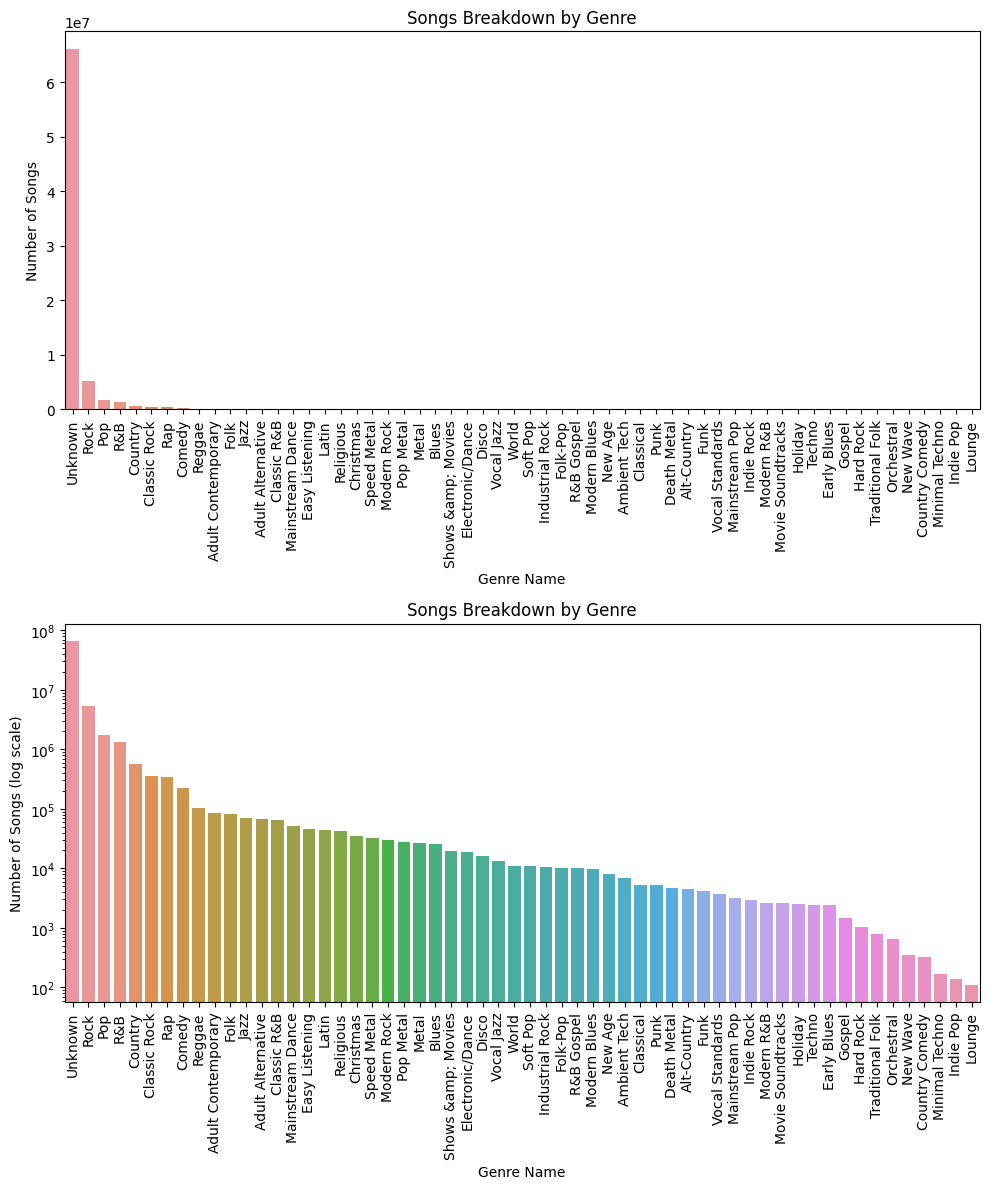

In [17]:
genre_song_count = df.groupBy('genre_name').agg(f.count('song_id').alias('genre_song_count'))
genre_song_count = genre_song_count.orderBy('genre_song_count', ascending=False)
genre_song_count_pdf = genre_song_count.toPandas()
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(data=genre_song_count_pdf, x='genre_name', y='genre_song_count', ax=axes[0])
axes[0].set_title('Songs Breakdown by Genre')
axes[0].set_xlabel('Genre Name')
axes[0].set_ylabel('Number of Songs')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(data=genre_song_count_pdf, x='genre_name', y='genre_song_count', ax=axes[1])
axes[1].set_title('Songs Breakdown by Genre')
axes[1].set_xlabel('Genre Name')
axes[1].set_ylabel('Number of Songs (log scale)')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Songs Breakdown by Top 10 Albums

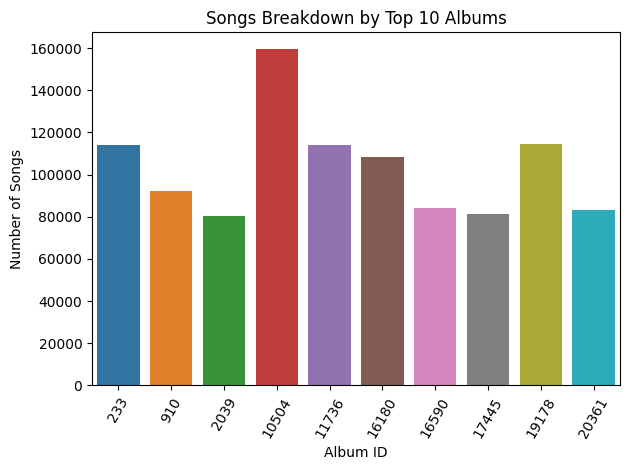

In [18]:
# song in album breakdown top 10 (determined by most rated songs in album)
album_song_count = df.groupBy('album_id').agg(f.count('song_id').alias('album_song_count'))

album_song_count = album_song_count.orderBy('album_song_count', ascending=False).limit(10)

album_song_count_pdf = album_song_count.toPandas()

sns.barplot(data=album_song_count_pdf, x='album_id', y='album_song_count')
plt.title('Songs Breakdown by Top 10 Albums')
plt.xlabel('Album ID')
plt.ylabel('Number of Songs')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

Songs Breakdown by Top 10 Artists

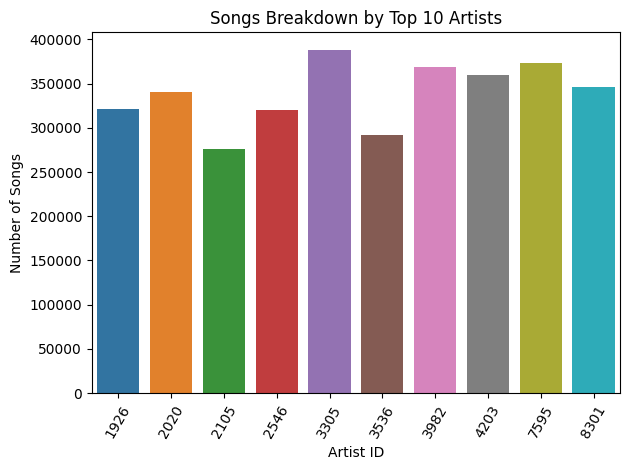

In [21]:
# song in artist breakdown top 10 (determined by most rated songs by artist)
artist_song_count = df.groupBy('artist_id').agg(f.count('song_id').alias('artist_song_count'))

artist_song_count = artist_song_count.orderBy('artist_song_count', ascending=False).limit(10)

artist_song_count_pdf = artist_song_count.toPandas()

sns.barplot(data=artist_song_count_pdf, x='artist_id', y='artist_song_count')
plt.title('Songs Breakdown by Top 10 Artists')
plt.xlabel('Artist ID')
plt.ylabel('Number of Songs')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()